In [26]:
# ! pip install fastai ipykernel torch torchaudio torchvision

In [36]:
from fastai import *
from fastai.vision.all import *
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
# device = torch.device("mps")
# # Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
# print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
# print(f"Is MPS available? {torch.backends.mps.is_available()}")
# print(f"Using device: {device}")

my_device = 'cuda'
torch.set_default_device(my_device)

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"



# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print(x)
# else:
#     print("MPS device not found.")


True
True


In [37]:
targets = torch.tensor([1, 2, 3]).device
targets


device(type='cpu')

In [38]:
project_directory = Path.cwd().joinpath('../')
path = project_directory.joinpath('data/mitochondria_data/training')
print(path)



/Users/ncamarda/Desktop/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training


In [39]:
image_files = sorted((path/'images').ls())
mask_files = sorted((path/'masks').ls())

size = np.unique([Image.open(f).size for f in image_files])[0]
print(size)


256


In [40]:
print(mask_files[0].name)
print(image_files[0].name)
print(image_files)

training_groundtruth_0_0_0.tif
training_0_0_0.tif
[Path('/Users/ncamarda/Desktop/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_0_0_0.tif'), Path('/Users/ncamarda/Desktop/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_0_0_1.tif'), Path('/Users/ncamarda/Desktop/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_0_0_2.tif'), Path('/Users/ncamarda/Desktop/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_0_0_3.tif'), Path('/Users/ncamarda/Desktop/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_0_1_0.tif'), Path('/Users/ncamarda/Desktop/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_0_1_1.tif'), Path('/Users/ncamarda/Desktop/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_0_1_2.tif'), Path('/Users/ncama

In [41]:

# Define a function to get the mask file path from an image file path
def get_mask_file(image_file):
    nums = re.findall(string=image_file.name, pattern = r"\d+_\d+_\d+")[0] # remove from list
    str_name = 'training_groundtruth_'+nums +'.tif'
    mask_path = (path/'masks'/str_name)
    return mask_path

# Create a DataBlock using the SegmentationDataLoaders.from_label_func method
mitos = DataBlock(blocks = (ImageBlock, MaskBlock(codes=[0,1])),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=get_mask_file,  # specify the function to get the mask file path
    item_tfms=Resize(int(size*2)),  # resize the images to a large size
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

# Use the DataBlock to create a DataLoaders object
# on Mac1 M1, you need to set the device here to CPU because some lin alg function isn't implemented for MPS
dls = mitos.dataloaders(path/"images", num_workers=4, device=my_device)


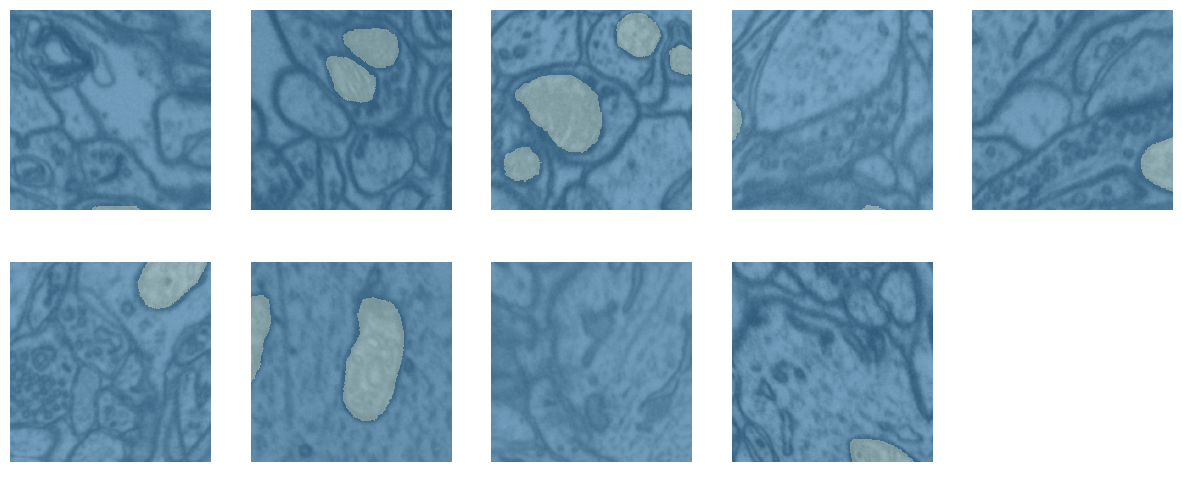

In [42]:
# show some batches
dls.show_batch(nrows=2)

In [43]:
x, y = dls.one_batch()
print("Input shape:", x.shape)
print("Target shape:", y.shape)


Input shape: torch.Size([64, 3, 224, 224])
Target shape: torch.Size([64, 224, 224])


In [46]:

learn = unet_learner(dls.to(my_device), resnet34, metrics=error_rate)
learn.fine_tune(2)


/opt/homebrew/Caskroom/miniforge/base/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous